In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

churn = pd.read_csv("https://raw.githubusercontent.com/rajeevratan84/datascienceforbusiness/master/WA_Fn-UseC_-Telco-Customer-Churn.csv")
mnist = datasets.load_digits()

 # Tree-Based Models: Classification Trees

We've discussed linear regression models and regression trees as tools for predicting a numerical response, but what if your response variable isn't numerical? What if we wish to predict whether a customer will default on a loan or not as a way to determine whether they should be granted a line of credit?

##### An Aside

You may have identified that, for the *default or not* example I provided, you could easily define `default` to the value 1 and `not` to the value 0. In fact, this is how we described *one-hot encodings* in the previous notebooks. If you are being perceptive, you might be excited -- could it be that building a regression model we could interpret its output as the *probability of default*? Probabilities are numeric values between 0 and 1, afterall. If you are even more observant, you may have already noticed that using this trick can't work. All of the regression models we've discussed are *multivariate polynomials* -- try to construct a polynomial in a single variable ($x$) that is bounded between 0 and 1...there's only one of them: $y = \beta_0$, the null model. 

Okay, so now that we know that approach has no hope of working, we can aknowledge a possibly more obvious reason for failure -- what if instead of `default` or `not`, we were working for Netflix trying to [classify subscribers into one of 2,000 micro-profiles](https://www.dativa.com/blogs/segmentation-relevant/) for their recommendation engine? There's certainly no natural way to define 0 or 1 here.

Okay, so linear regression won't work and we need new tools. There have been multiple tools developed for tackling inference and prediction tasks within *classification*. We look at two of these methods in our class: *tree-based classifiers* and *logistic regressors*. This notebook introduces tree-based classifiers and next week we will consider logistic regression. We'll consider two separate datasets and objectives this week. 

+ **Application I (Customer Churn):** Our first dataset deals with the challenge of customer *churn* -- this typically involves customers with a subscriprion-based service choosing to terminate or not renew their contracts. Companies with a subscription-based model seek to identify customers at risk of *churning* and to pre-emptively outreach with enticing offers, to convince them to remain a subscriber. Predicting *churn* is known as a binary classification problem -- since customers either churn (1) or remain (0).
+ **Application II (Digit Recognization):** Our second dataset deals with classifying handwritten digits. In this application there are ten classes in the target variable -- we have a more difficult job ahead of us.

## Introducing our *churn* data

Our dataset deals with customer *churn*.

***Customer Churn*** - churn is when an existing customer, user, player, subscriber or any kind of return client stops doing business or ends the relationship with a company.

**Aim -** is to figure our which customers may likely churn in future

Source - https://www.kaggle.com/blastchar/telco-customer-churn
1. We have customer information for a Telecommunications company
2. We've got customer IDs, general customer info, the servies they've subscribed too, type of contract and monthly charges.
3. This is a historic customer information so we have a field stating whether that customer has **churned**.

You can see the *head* of the dataset below.

In [ ]:
churn.head()

**Variable Descriptions**
- customerID - Customer ID
- gender - Whether the customer is a male or a female
- SeniorCitizen - Whether the customer is a senior citizen or not (1, 0)
- Partner - Whether the customer has a partner or not (Yes, No)
- Dependents - Whether the customer has dependents or not (Yes, No)
- tenure - Number of months the customer has stayed with the company
- PhoneService - Whether the customer has a phone service or not (Yes, No)
- MultipleLines - Whether the customer has multiple lines or not (Yes, No, No phone service)
- InternetService - Customer’s internet service provider (DSL, Fiber optic, No)
- OnlineSecurity - Whether the customer has online security or not (Yes, No, No internet service)
- OnlineBackup - Whether the customer has online backup or not (Yes, No, No internet service)
- DeviceProtection - Whether the customer has device protection or not (Yes, No, No internet service)
- TechSupport - Whether the customer has tech support or not (Yes, No, No internet service)
- StreamingTV - Whether the customer has streaming TV or not (Yes, No, No internet service)
- StreamingMovies - Whether the customer has streaming movies or not (Yes, No, No internet service)
- Contract - The contract term of the customer (Month-to-month, One year, Two year)
- PaperlessBilling - Whether the customer has paperless billing or not (Yes, No)
- PaymentMethod - The customer’s payment method (Electronic check, Mailed check Bank transfer (automatic), Credit card (automatic))
- MonthlyCharges - The amount charged to the customer monthly
- TotalCharges - The total amount charged to the customer
- Churn - Whether the customer churned or not (Yes or No)

## Using trees for classification

Add a description of trees for classification, in particular the tree-fitting algorithm.

## Preparing our data

Below we start the initial data cleaning process and then split our data into *training* and *safe* sets -- we won't use a separate *test* set now, since we know about *cross-validation*. Remember, that $k$-fold cross validation splits the data into $k$ *folds*, where each fold takes one turn being left out of the model fitting process, and is used as a validation set. The benefit to $k$-fold cross validation is that we estimate $k$ separate validation errors and can aggregate them into a single cross-validation error rate, which better approximates the true prediction error.

We'll start by checking for missing data and then get dummy variables for any categorical columns.

In [2]:
churn.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

Our dataset does require some pre-processing. For example, there are lots of categorical columns that we need transformed into "dummy" columns just like we did with our regression models. I'll walk you through some automated pre-processing steps below -- be sure to work with me through the code so that you understand what each line is doing.

In [3]:
churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


It seems as though there are a lot of columns which are listed as the *object* class -- this means they are non-numerics. From the descriptions of the variables we saw earlier, this seems to be appropriate in all cases except for the `TotalCharges` column. We can see what is going wrong if we print out the `TotalCharges` column -- if you uncomment that line in the code cell below and scroll through the column entries you will find a few entries which contain a *space*, so they are not technically null. Since there are not many of these entries we will just drop them here for convenience and then convert the column to numeric values. What is dangerous about this approach?

In [4]:
#print(list(churn["TotalCharges"]))
print(churn.shape)
churn = churn[churn["TotalCharges"] != " "]
churn["TotalCharges"] = pd.to_numeric(churn["TotalCharges"])
print(churn.shape)

(7043, 21)
(7032, 21)


 Now let's see what we can do to get dummy variables for these categorical variables.

In [5]:
num_cols = ["tenure", "MonthlyCharges", "TotalCharges"]
unique_id = ["customerID"]

#We could just type out a list of the categorical columns, but this is a bit shorter
cat_cols = [name for name in list(churn.columns) if ((name not in num_cols) & (name not in unique_id))]

churn = pd.get_dummies(churn, columns = cat_cols, drop_first = True)
churn.head()

,customerID,tenure,MonthlyCharges,TotalCharges,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_Yes
0,7590-VHVEG,1,29.85,29.85,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
1,5575-GNVDE,34,56.95,1889.50,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0
2,3668-QPYBK,2,53.85,108.15,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1
3,7795-CFOCW,45,42.30,1840.75,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0
4,9237-HQITU,2,70.70,151.65,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1


You may have noticed that, in the previous cell, we labeled `customerID` as something called a *unique identifier*. This is a non-numeric value which is unique to each observation. If we included it in our model, we could construct a perfect classifier. This sounds like a really good thing -- but, unfortunately if we used `customerID` as a predictor our classifier would be useless when applied to new data. The classifier including this variable would essentially become a *look-up table* -- find the customer with the corresponding `customerID` look to the last column of the table in that row and report back whether or not the customer *churned*. Such a model would fail on any data it was not trained on -- for this reason, we never want to include a unique identifier as a predictor in a model. Let's drop it now and then use `train_test_split` to create our *training* and *safe* sets. Since we'll use cross-validation now, there's no need to create a separate *test* set any longer.

In [6]:
churn.drop(["customerID"], axis = 1, inplace = True)

X = churn.drop(["Churn_Yes"], axis = 1)
y = churn["Churn_Yes"]

X_train, X_safe, y_train, y_safe = train_test_split(X, y, test_size = 0.1, random_state = 42)

X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6328 entries, 6183 to 862
Data columns (total 30 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   tenure                                 6328 non-null   int64  
 1   MonthlyCharges                         6328 non-null   float64
 2   TotalCharges                           6328 non-null   float64
 3   gender_Male                            6328 non-null   uint8  
 4   SeniorCitizen_1                        6328 non-null   uint8  
 5   Partner_Yes                            6328 non-null   uint8  
 6   Dependents_Yes                         6328 non-null   uint8  
 7   PhoneService_Yes                       6328 non-null   uint8  
 8   MultipleLines_No phone service         6328 non-null   uint8  
 9   MultipleLines_Yes                      6328 non-null   uint8  
 10  InternetService_Fiber optic            6328 non-null   uint8  
 11  In

Now that we have the training and safe data, let's see if we can build a decision tree. Decision tree classifiers are quite similar to decision tree regressors -- the model is still a decision tree which asks a series of yes/no questions. Observations land in leaf nodes and all observations falling in the same leaf node are assigned to the same class -- the most prevalent class within that leaf. Remember that unconstrained trees are enticed to overfit, so we will use cross-validation and some regularization constraints to fit various trees.

In [7]:
max_depth = [3, 4, 5, 8, 10]
min_samples = [0.005, 0.01, 0.02, 0.05]

for depth in max_depth:
    for minSamp in min_samples:
        tree_clf = DecisionTreeClassifier(max_depth = depth, min_samples_split = minSamp)
        
        cv_results = cross_val_score(tree_clf, X_train, y_train, cv = 10, scoring = "accuracy")
        print("Max depth ", depth, ", minimum bucket size for splitting (as a proportion) ", minSamp, ":")
        print("\t Accuracy Rates: ", cv_results)
        print("\t Mean accuracy: ", cv_results.mean())
        

Max depth  3 , minimum bucket size for splitting (as a proportion)  0.005 :
	 Accuracy Rates:  [0.79778831 0.77409163 0.78672986 0.78830964 0.78830964 0.78041074
 0.79146919 0.79462875 0.78797468 0.81487342]
	 Mean accuracy:  0.7904585857979882
Max depth  3 , minimum bucket size for splitting (as a proportion)  0.01 :
	 Accuracy Rates:  [0.79778831 0.77409163 0.78672986 0.78830964 0.78830964 0.78041074
 0.79146919 0.79462875 0.78797468 0.81487342]
	 Mean accuracy:  0.7904585857979882
Max depth  3 , minimum bucket size for splitting (as a proportion)  0.02 :
	 Accuracy Rates:  [0.79778831 0.77409163 0.78672986 0.78830964 0.78830964 0.78041074
 0.79146919 0.79462875 0.78797468 0.81487342]
	 Mean accuracy:  0.7904585857979882
Max depth  3 , minimum bucket size for splitting (as a proportion)  0.05 :
	 Accuracy Rates:  [0.79778831 0.77409163 0.78672986 0.78830964 0.78830964 0.78041074
 0.79146919 0.79462875 0.78797468 0.81487342]
	 Mean accuracy:  0.7904585857979882
Max depth  4 , minimum 

The results of cross-validation seem to suggest we get about 79% accuracy using `max_depth = 3`, and with this parameter it looks like changing the `min_samples_split` parameter did not impact training. This makes sense, since buckets are unlikely to contain a very small number of observations with just three levels of splitting. Let's see how our model actually performs on the training data by re-fitting and building a confusion matrix. You can see a visual of our model and the confusion matrix output below.

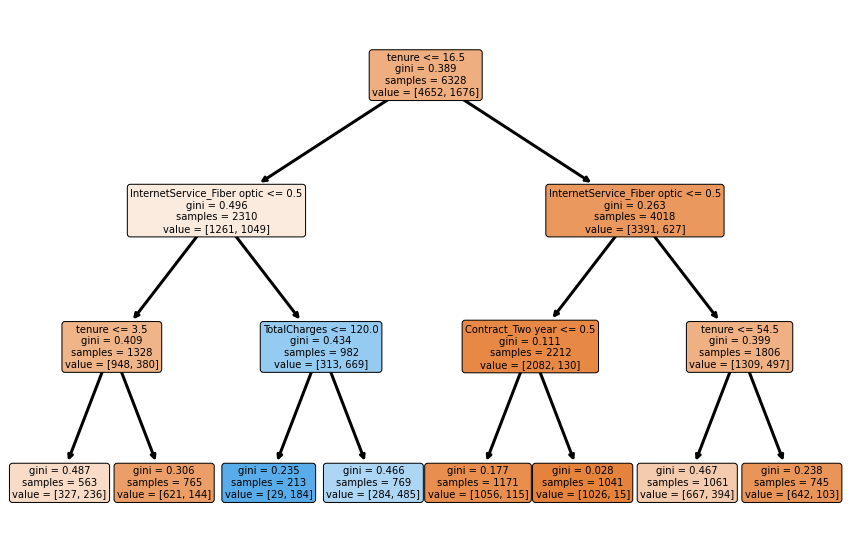

Confusion matrix:
 [[4339  313]
 [1007  669]]


In [8]:
tree_clf = DecisionTreeClassifier(max_depth = 3)

tree_clf.fit(X_train, y_train)

plt.figure(figsize = (15, 10))
out = plot_tree(tree_clf, feature_names = X_train.columns, filled = True, rounded = True, fontsize = 10)
for o in out:
    arrow = o.arrow_patch
    if arrow is not None:
        arrow.set_edgecolor('black')
        arrow.set_linewidth(3)
plt.show()

print("Confusion matrix:\n",confusion_matrix(y_train, tree_clf.predict(X_train)))

In the confusion matrix above, the rows correspond to the true class that the customer belongs to. The first row contains customers who did not churn (`Churn_Yes` = 0) while the second row contains customers who did churn. The columns correspond to our predictions -- again, the first column corresponds to customers who we did not expect to churn while the second column corresponds to customers who we did expect to churn. We correctly flagged 669 customers who churned but missed 1007 additional customers who churned. Refer back to our discussion on model validation metrics for the definitions of *accuracy*, *precision*, and *recall* if you need to. Our accurracy rate for this model was 79.14%, our recall rate was 39.92% (which is not so great), and our precision was 63.13%. I think we would be willing to sacrifice some of our accuracy rate and precision in order to gain some recall. Remember, the goal here was to build a model which would inform outreach efforts to customers who are at risk for *churn*. See what you can do to build a model with better recall! Once you have one, see how well it does on the *safe* data.

Now that we've dealt with binary classification, let's move to predicting a response with more than just two classes.

## The multiclass setting for classification

In this section, we'll explore an application of classification where the target is not binary -- instead, our target will include ten different classes. We'll work with a famous dataset called `mnist` which includes 1797 hand-drawn digits. Our goal will be to build a classification tree to identify the drawn digits. This is an interesting problem because it involves something called *computer vision* -- the computer can't actually "see" the image of the digit, so how do we train the computer to identify the digits? We'll unpack each 8 pixel by 8 pixel image into a list of 64 grayscale values. This will give us a dataset with 64 features from which, we will try to build a decision tree to classify the digits.

Below, we split the `mnist` data into a *training*, *test*, and *safe* set. Additionally, we print out the grayscale values corresponding to the first five digits in the training data, and plot the image corresponding to the first drawn digit as well as print its label. Do you think we'll have an easy or difficult time distinguishing these digits from one another?

[[ 0.  0.  2. 15. 15. 16. 11.  0.  0.  0.  8. 16. 11.  3.  0.  0.  0.  0.
  13.  9.  0.  0.  0.  0.  0.  5. 16.  3.  9. 11.  3.  0.  0. 10. 15. 15.
  16. 16. 11.  0.  0.  6. 16. 10.  7. 16.  5.  0.  0.  0.  3.  4. 15.  8.
   0.  0.  0.  0.  4. 15.  7.  0.  0.  0.]
 [ 0.  5. 16. 15.  3.  0.  0.  0.  0. 11. 14. 11. 11.  0.  0.  0.  0.  8.
  11.  4. 16.  0.  0.  0.  0.  0.  0.  4. 13.  0.  0.  0.  0.  0.  0.  8.
  12.  0.  0.  0.  0.  0.  0. 13.  9.  5.  1.  0.  0.  1. 11. 16. 16. 16.
  10.  0.  0.  5. 16. 14.  8.  6.  1.  0.]
 [ 0.  0.  4. 13.  8.  0.  0.  0.  0.  0. 13. 16. 15.  7.  0.  0.  0.  3.
  16.  9.  6. 15.  6.  0.  0.  8. 14.  0.  0.  4.  8.  0.  0.  8. 12.  0.
   0.  4.  8.  0.  0.  4. 12.  0.  0. 11.  6.  0.  0.  0. 14. 10. 12. 14.
   1.  0.  0.  0.  7. 15. 11.  2.  0.  0.]
 [ 0.  0.  3. 13. 13.  3.  0.  0.  0.  2. 14. 12. 12. 11.  0.  0.  0.  4.
  16.  8.  5. 15.  3.  0.  0.  1. 13. 14. 16.  7.  0.  0.  0.  0. 11. 16.
  13.  1.  0.  0.  0.  1. 16. 12. 13. 14.  1.  0.  0.  0.

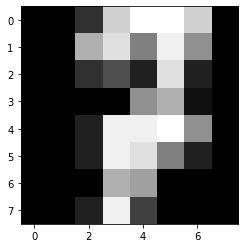

In [9]:
mnist
digits_train, digits_temp, labels_train, labels_temp = train_test_split(mnist["data"], mnist["target"], test_size = 0.25, random_state = 42)
digits_safe, digits_test, labels_safe, labels_test = train_test_split(digits_temp, labels_temp, test_size = 0.6, random_state = 42)
print(digits_train[:6, :])
plt.imshow(digits_train[4].reshape(8,8), cmap = "gray")
print("The true label is: ", labels_train[4])

In [10]:
tree_clf = DecisionTreeClassifier()

cv_scores = cross_val_score(tree_clf, digits_train, labels_train, cv = 10, scoring = "accuracy")

print(cv_scores)
print("Cross-Validation Error Estimate: ", 1 - (cv_scores.mean()))

[0.78518519 0.81481481 0.87407407 0.86666667 0.8        0.84444444
 0.81481481 0.79104478 0.79850746 0.87313433]
Cross-Validation Error Estimate:  0.17373134328358208


We got around a 16% to 18% cross-validation error rate (about 82% to 84% accuracy) -- that seems pretty good. With random guessing we would have expected about a 90% error rate, so this is much better than that. Let's see how our model does on the test data.

In [11]:
tree_clf.fit(digits_train, labels_train)

cm = confusion_matrix(labels_test, tree_clf.predict(digits_test))
print("Confusion Matrix: \n", cm)

Confusion Matrix: 
 [[26  0  0  0  3  1  0  0  0  0]
 [ 0 24  1  0  1  0  0  0  1  0]
 [ 1  1 17  3  0  0  0  1  1  0]
 [ 0  0  0 27  0  0  0  1  3  0]
 [ 0  1  0  0 25  0  0  0  0  1]
 [ 0  1  0  0  0 23  0  0  1  3]
 [ 0  0  0  0  0  1 20  0  0  1]
 [ 0  0  0  1  2  0  0 25  0  0]
 [ 1  3  1  1  1  0  0  0 20  0]
 [ 0  1  0  2  0  0  0  0  0 23]]


In [12]:
correct = 0
for i in list(range(10)):
    correct = correct + cm[i,i]

accuracy = correct/len(digits_test)
print("Accuracy Rate: ", accuracy)

Accuracy Rate:  0.8518518518518519


An accuracy rate of about 85.6% agrees with our cross-validation error rate. Can you identify the numbers that our model has difficulty differentiating between? Did you expect this (or should we have expected it)?

Thinking back to our classification tree, while we may not be overfitting is it possible that we are leaving predictive power "on the table"? I bet you can do better. Remember that you should be building lots of competing models and using cross-validation to tune hyperparameters and to compare those models. Take some time here to try it, and then see how your best model performs on the *safe* set. Can you get above 90% accuracy?

## Summary

That's it from me for now. In this notebook you learned how decision tree classifiers work and you applied them in two different scenarios. Decision trees are nice because they are so easily understood -- a non-expert can look at one and understand what is happening. Additionally, decision trees can handle the multiclass case without any extra work. What may not be so great about decision trees is that they don't typically provide us with a measure of how confident we are in our prediction (the *propensity*) -- although we can make them do it. Next week we will look at one more type of model which can be used for classification -- the *logistic regression* model. See you then!